# Project 4: Hackathon

### Apple Stock Data: 2006 - 2016

Data Sources: https://www.kaggle.com/BidecInnovations/stock-price-and-news-realted-to-it/code

### Problem Statement: 
Determine whether a stock price will close up or down based on the news released about the stock during a trading day.

### Executive Summary

This Analysis examined dataset on Apple stock price between December 2006 and November 2016 to test whether published news impacts stock price direction. I used 5 models to test my hypothesis with the best using Linear Regression with 53% accuracy - slightly higher than the Null Model with 50.5% accuracy. As a conclusion: news as a stand-alone is not a great predictor of a stock price direction with a caveat that the news sample is relevant to the stock. 

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, confusion_matrix, roc_auc_score, precision_score
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import EarlyStopping

In [3]:
apple = pd.read_csv('data/AppleNewsStock.csv')

In [4]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News
0,2006-12-01,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,2006-12-04,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...
2,2006-12-05,13.092857,13.190000,12.981428,91.269997,13.038571,165709600,NaN
3,2006-12-06,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,Honoring R.W. Apple in Words and Food : About ...
4,2006-12-07,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [5]:
apple['Date'].max() # the data ends in November 2016

'2016-11-30'

In [6]:
apple['Date'].min() # starts in December 2006

'2006-12-01'

In [7]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2517 non-null   object 
 1   Open       2517 non-null   float64
 2   High       2517 non-null   float64
 3   Low        2517 non-null   float64
 4   Close      2517 non-null   float64
 5   Adj Close  2517 non-null   float64
 6   Volume     2517 non-null   int64  
 7   News       2323 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 157.4+ KB


In [8]:
apple.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
News         194
dtype: int64

In [9]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,60.719774,61.302098,60.065740,260.556404,60.695236,1.345639e+08
std,36.218609,36.482248,35.930683,175.576176,36.204898,9.904975e+07
min,11.164286,11.607142,10.967143,78.199997,11.171429,1.147590e+07
25%,25.577143,25.857143,25.049999,112.879997,25.540001,6.363350e+07
50%,57.142857,57.655716,56.480000,179.300003,57.104286,1.077881e+08
75%,93.790001,94.639999,92.680000,400.289978,93.699997,1.774899e+08
max,134.460007,134.539993,131.399994,702.100037,133.000000,8.432424e+08


In [10]:
# drop rows with missing news column
apple.dropna(axis = 0, inplace = True)

In [11]:
apple.columns = apple.columns.str.lower()

In [12]:
# engineer a variable up or down 
apple['up_or_down'] = apple['adj close'] - apple['open']

In [13]:
# create a function for up or down column
def up_or_down(number):
    if number < 0:
        return 'down'
    if number > 0:
        return 'up'   

In [14]:
# apply function
apple['up_or_down'] = apple['up_or_down'].apply(up_or_down)

In [15]:
# set date as index column
apple.set_index(['date'], inplace = True)

In [16]:
apple.head(2)

,open,high,low,close,adj close,volume,news,up_or_down
date,,,,,,,,
2006-12-01,13.114285,13.19,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...,down
2006-12-04,13.125714,13.15,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...,down


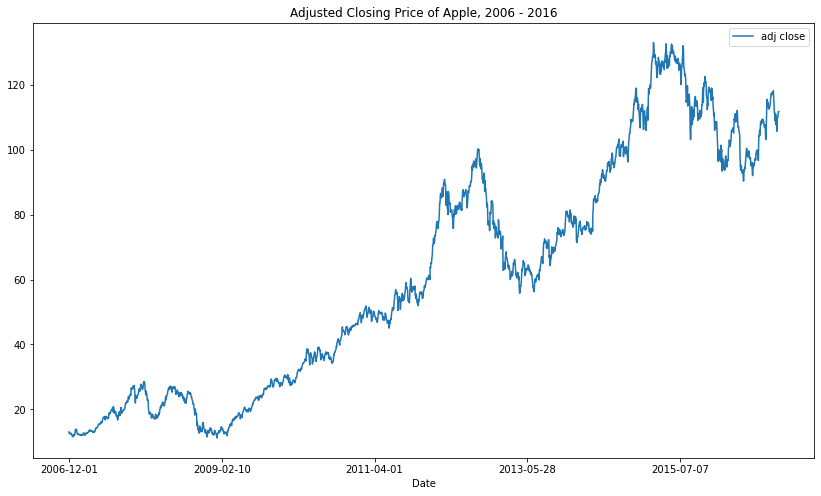

In [17]:
apple['adj close'].plot(figsize = (14, 8), title = 'Adjusted Closing Price of Apple, 2006 - 2016')
plt.xlabel('Date')
plt.legend();

In [18]:
apple['adj close'].max() # the stock grew 12x times in ten years

133.0

In [19]:
apple['adj close'].min()

11.171429

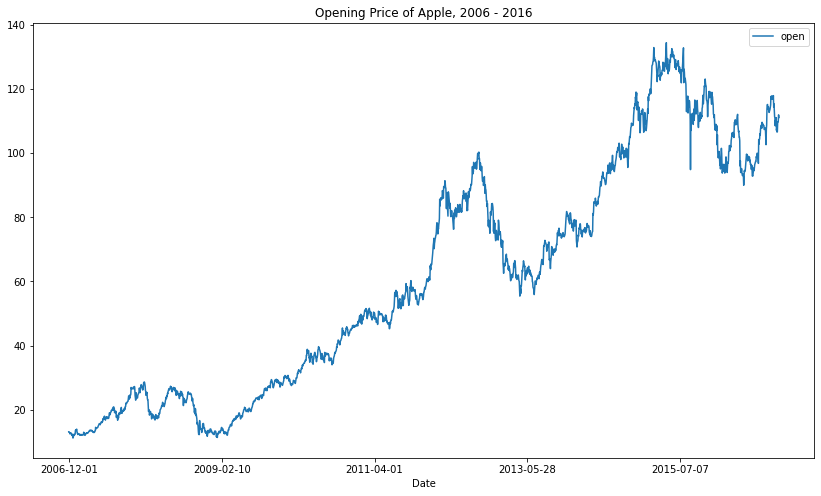

In [20]:
apple['open'].plot(figsize = (14, 8), title = 'Opening Price of Apple, 2006 - 2016')
plt.xlabel('Date')
plt.legend();

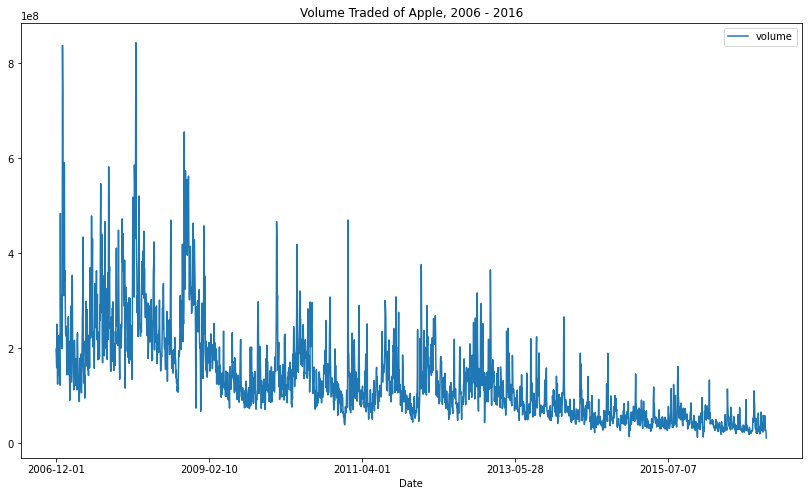

In [21]:
apple['volume'].plot(figsize = (14, 8), title = 'Volume Traded of Apple, 2006 - 2016')
plt.xlabel('Date')
plt.legend();

In [22]:
apple['volume'].min() # currently 110m shares a day, 

11475900

In [23]:
apple['volume'].max() # traded in higher volumes when was cheaper 834m shares / daily max

843242400

### Countvectorizing news articles

In [24]:
cvect_apple = CountVectorizer(stop_words = 'english', ngram_range = (3,3), max_features = 500)

In [25]:
news_vect_apple = cvect_apple.fit_transform(apple['news'])

In [26]:
apple_vect = pd.DataFrame(news_vect_apple.toarray(), columns = cvect_apple.get_feature_names())

In [27]:
apple_vect.sum().sort_values(ascending = False).head(20)

new york times                  354
new york city                   207
need know start                 153
know start day                  142
briefing need know              124
paid notice deaths              101
editors new york                 96
reporters editors new            96
technology reporters editors     94
york times scour                 93
times scour web                  93
web important peculiar           92
scour web important              90
important peculiar items         84
spare times children             77
corrections appearing print      67
today small business             65
inside times international       63
big apple circus                 62
daily report apple               53
dtype: int64

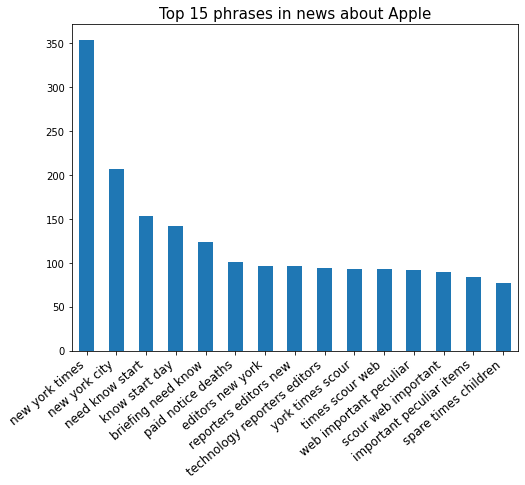

In [30]:
plt.figure(figsize = (8, 6))
apple_vect.sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('Top 15 phrases in news about Apple', fontsize = 15)
plt.xticks(ha='right', rotation=40, fontsize=12)
plt.yticks(fontsize = 10);

In [31]:
# news mentioning apple
[i for i in apple['news'] if 'apple' in i.lower()][:1]

["Honoring R.W. Apple in Words and Food : About 1,000 of R.W. Apple’s admirers turned out for a funny, sad and immensely caloric tribute to The New York Times writer at the Kennedy Center memorial on Tuesday.Bono's Elevation Seeks Time's Parenting Titles, Report Says : On the heels of news that the auction for Time Inc.'s Time4Media publications had stalled, the New York Post reported that Elevation Partners, the private equity group founded by philanthropist and sometime rocker Bono, has entered the fray. The b...Defense Nominee Gains Approval of Senate Panel : Robert M. Gates said the recommendations to be made public this morning by the Iraq Study Group would be important but not “the last word.”"]

### Sentiment Analysis: Apple

In [32]:
sentiment_objects_apple = [TextBlob(i) for i in apple['news']]

In [33]:
sentiment_values_apple = [[i.sentiment.polarity, str(i)] for i in sentiment_objects_apple]

In [34]:
sentiment_df_apple = pd.DataFrame(sentiment_values_apple, columns = ['polarity', 'news'])

In [35]:
sentiment_df_apple.sort_values(by = 'polarity', ascending = False).head(10)

,polarity,news
679,0.544444,"Sweet Potato, Pumpkin and Apple Puree : This m..."
1080,0.433333,What We’re Reading : A collection of links by ...
93,0.429545,A Media PC That Can Stand Up Next to the Telev...
953,0.419481,Verizon Deal May Expose iPhone Flaws : The pro...
2119,0.400000,Breaking Up With Apple Music : If you have rea...
1633,0.398312,Korean Court Rejects Samsung Lawsuit Against A...
916,0.385845,Video: How to Make the Perfect Pie Crust : Wee...
1088,0.383690,Will Apple Remain a Hedge Fund Favorite? : Man...
1136,0.370707,What Are the Best Apples for Apple Pie? : In a...
1146,0.366855,A Hard Cider From an Heirloom Apple : The Newt...


In [36]:
sentiment_df_apple.sort_values(by = 'polarity', ascending = True).head(10)

,polarity,news
1224,-0.287879,Congress Extends Road Funds by 90 Days : Unabl...
823,-0.225000,Germany Asks Apple About iPhone&#8217;s Data-G...
1737,-0.220833,China Pulls Cisco Into Dispute on Cyberspying ...
611,-0.200000,Walt Disney Says Profit Fell 26% in Quarter : ...
1865,-0.175000,Adam's Apples Scene: Apple Tree : A Model T Co...
1955,-0.175000,Market Mostly Higher as Company Earnings Repor...
1203,-0.152540,Photos Vulnerable on Apple Devices : 8:19 p.m....
2210,-0.150974,Apple Case Underscores Pitfalls of Doing Busin...
782,-0.150000,"Apple Buys Intrinsity, a Maker of Fast Chips :..."
164,-0.141477,"Already, Apple Sells Refurbished iPhones : Con..."


In [37]:
sentiment_df_apple = sentiment_df_apple[sentiment_df_apple.polarity != 0]

In [38]:
sentiment_df_apple.mean()

polarity    0.111278
dtype: float64

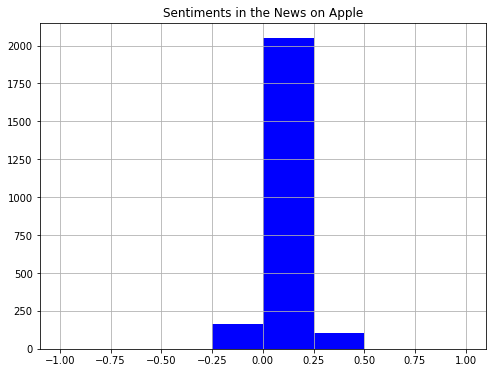

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df_apple.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="blue")

plt.title("Sentiments in the News on Apple");

In [40]:
# concat polarity df with apple df on 'news'
apple_final = pd.merge(apple, sentiment_df_apple, on='news')

In [41]:
# dropping rows with missing values
apple_final.dropna(axis = 0, inplace = True)

In [42]:
# save to csv 
apple_final.to_csv('data/apple_clean.csv')

In [43]:
# add polarity to countvectorized dataframe
apple_vect['polarity'] = apple_final['polarity']

In [44]:
# add y value to countvectorized dataframe
apple_vect['up_or_down'] = apple_final['up_or_down']

In [45]:
apple_vect.dropna(axis = 0, inplace = True)

In [46]:
apple_vect.to_csv('data/apple_vect_clean.csv')

### Null Model

In [47]:
apple_final['up_or_down'].value_counts(normalize=True) # null model is just a little over 50% accurate

up      0.505837
down    0.494163
Name: up_or_down, dtype: float64

### Train Test Split

In [48]:
X = apple_vect.drop(columns = 'up_or_down')
y = apple_vect['up_or_down']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

### 1. Logistic Regression

In [50]:
pipe_lr = make_pipeline(StandardScaler(with_mean=False), LogisticRegression())

In [51]:
pipe_lr.fit(X_train, y_train)

c:\users\anel akiyanova\anaconda3\envs\new\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression())])

In [52]:
pipe_lr.score(X_train, y_train) #overfit model

0.6735870818915801

In [53]:
pipe_lr.score(X_test, y_test)

0.5129533678756477

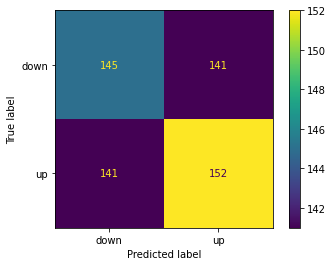

In [76]:
# plot confusion matrix 
plot_confusion_matrix(pipe_lr, X_test, y_test);

### 2. CountVectorizer / Naive Bayes only using the news variable

In [86]:
X_news = apple_final['news']
y_news = apple_final['up_or_down']

In [88]:
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news, y_news)

In [90]:
pipe_nb = make_pipeline(CountVectorizer(stop_words = 'english', ngram_range = (1,1)), MultinomialNB())

In [91]:
pipe_nb.fit(X_train_news, y_train_news)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [93]:
pipe_nb.score(X_train_news, y_train_news)

0.9786620530565168

In [94]:
pipe_nb.score(X_test_news, y_test_news)

0.47150259067357514

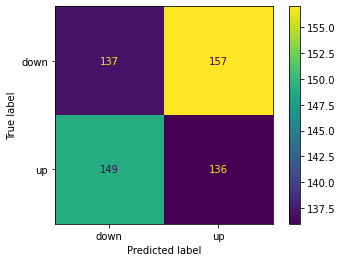

In [95]:
# plot confusion matrix 
plot_confusion_matrix(pipe_nb, X_test_news, y_test_news);

### 3. GradientBoosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
pipe_boost = make_pipeline(GradientBoostingClassifier())

In [59]:
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])

In [60]:
pipe_boost.score(X_train, y_train)

0.6528258362168397

In [61]:
pipe_boost.score(X_test, y_test)

0.5164075993091537

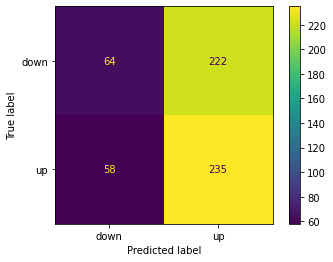

In [75]:
# plot confusion matrix 
plot_confusion_matrix(pipe_boost, X_test, y_test);

### 4. LR using only news sentiment

In [62]:
X2 = apple_final[['polarity']]
y2 = apple_final['up_or_down']

In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

In [64]:
pipe_lr2 = make_pipeline(StandardScaler(), LogisticRegression())

In [65]:
pipe_lr2.fit(X_train2, y_train2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [67]:
pipe_lr2.score(X_train2, y_train2)

0.5011534025374856

In [68]:
pipe_lr2.score(X_test2, y_test2)

0.538860103626943

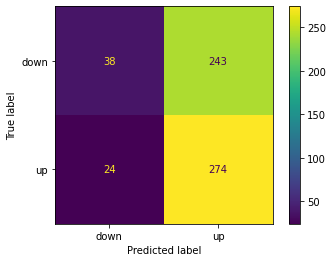

In [74]:
# plot confusion matrix 
plot_confusion_matrix(pipe_lr2, X_test2, y_test2);

### 5. SVC using news sentiment

In [69]:
pipe_svc = make_pipeline(StandardScaler(with_mean = False), SVC())

In [70]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC())])

In [71]:
pipe_svc.score(X_train, y_train)

0.7381776239907728

In [72]:
pipe_svc.score(X_test, y_test)

0.5094991364421416

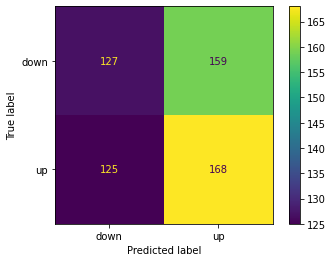

In [73]:
# plot confusion matrix 
plot_confusion_matrix(pipe_svc, X_test, y_test);

### Conclusion and Recommendations: 

 - News as a stand-alone is not a great predictor of a stock price direction. **Caveat:** subject to the news sample being relevant to the stock.
 - Add polarity sentiment of news to test if that changes model accuracy

### 6. CountVectorizer / Neural Network 

In [ ]:
from keras.utils import to_categorical

In [ ]:
y_cat = tf.keras.utils.to_categorical(y, num_classes=2)

In [ ]:
cvect_nn = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features = 1000)

In [ ]:
X_train_vect = cvect_nn.fit_transform(X_train).toarray()

In [ ]:
X_test_vect = cvect_nn.transform(X_test).toarray()

In [ ]:
model = Sequential()
model.add(Input(501, ))
model.add(BatchNormalization())
model.add(Dense(30, activation = 'relu'))
model.add(Dense(12, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
early_stop = EarlyStopping(patience = 5)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    batch_size=50,
    epochs=50
)

### 7. Neural Network using polarity

In [ ]:
model = Sequential()
model.add(Input(1, ))
model.add(BatchNormalization())
model.add(Dense(30, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                   epochs = 20)